In [1]:
def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):

    import numpy as np
    from scipy.stats import norm
    '''
    Get a prediction interval for a linear regression.
    
    INPUTS: 
        - Single prediction, 
        - y_test
        - All test set predictions,
        - Prediction interval threshold (default = .95) 
    OUTPUT: 
        - Prediction interval for single prediction
    '''
    
    #get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = norm.ppf(ppf_lookup)
    interval = z_score * stdev
#generate prediction interval lower and upper bound
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper


In [2]:
file_data = "/content/drive/My Drive/PROJETS/EE-Waternamics/Data/donnees_horaires_narbonne.csv"
import pandas as pd
data = pd.read_csv(file_data)

dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
data = pd.read_csv(file_data,parse_dates=True,date_parser=dateparse,low_memory = False,index_col=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """


In [3]:
data.dropna(inplace=True)
data.drop(columns=['Nbre_equip_fct','MES_CHENAL_OXYDATION_F1_1', 'MES_CHENAL_OXYDATION_F1_2','MES_CHENAL_OXYDATION_FILE_2_1','MES_CHENAL_OXYDATION_FILE_2_2','MODULE_BD1'], inplace=True)

# Feature sélection with covariance matrix

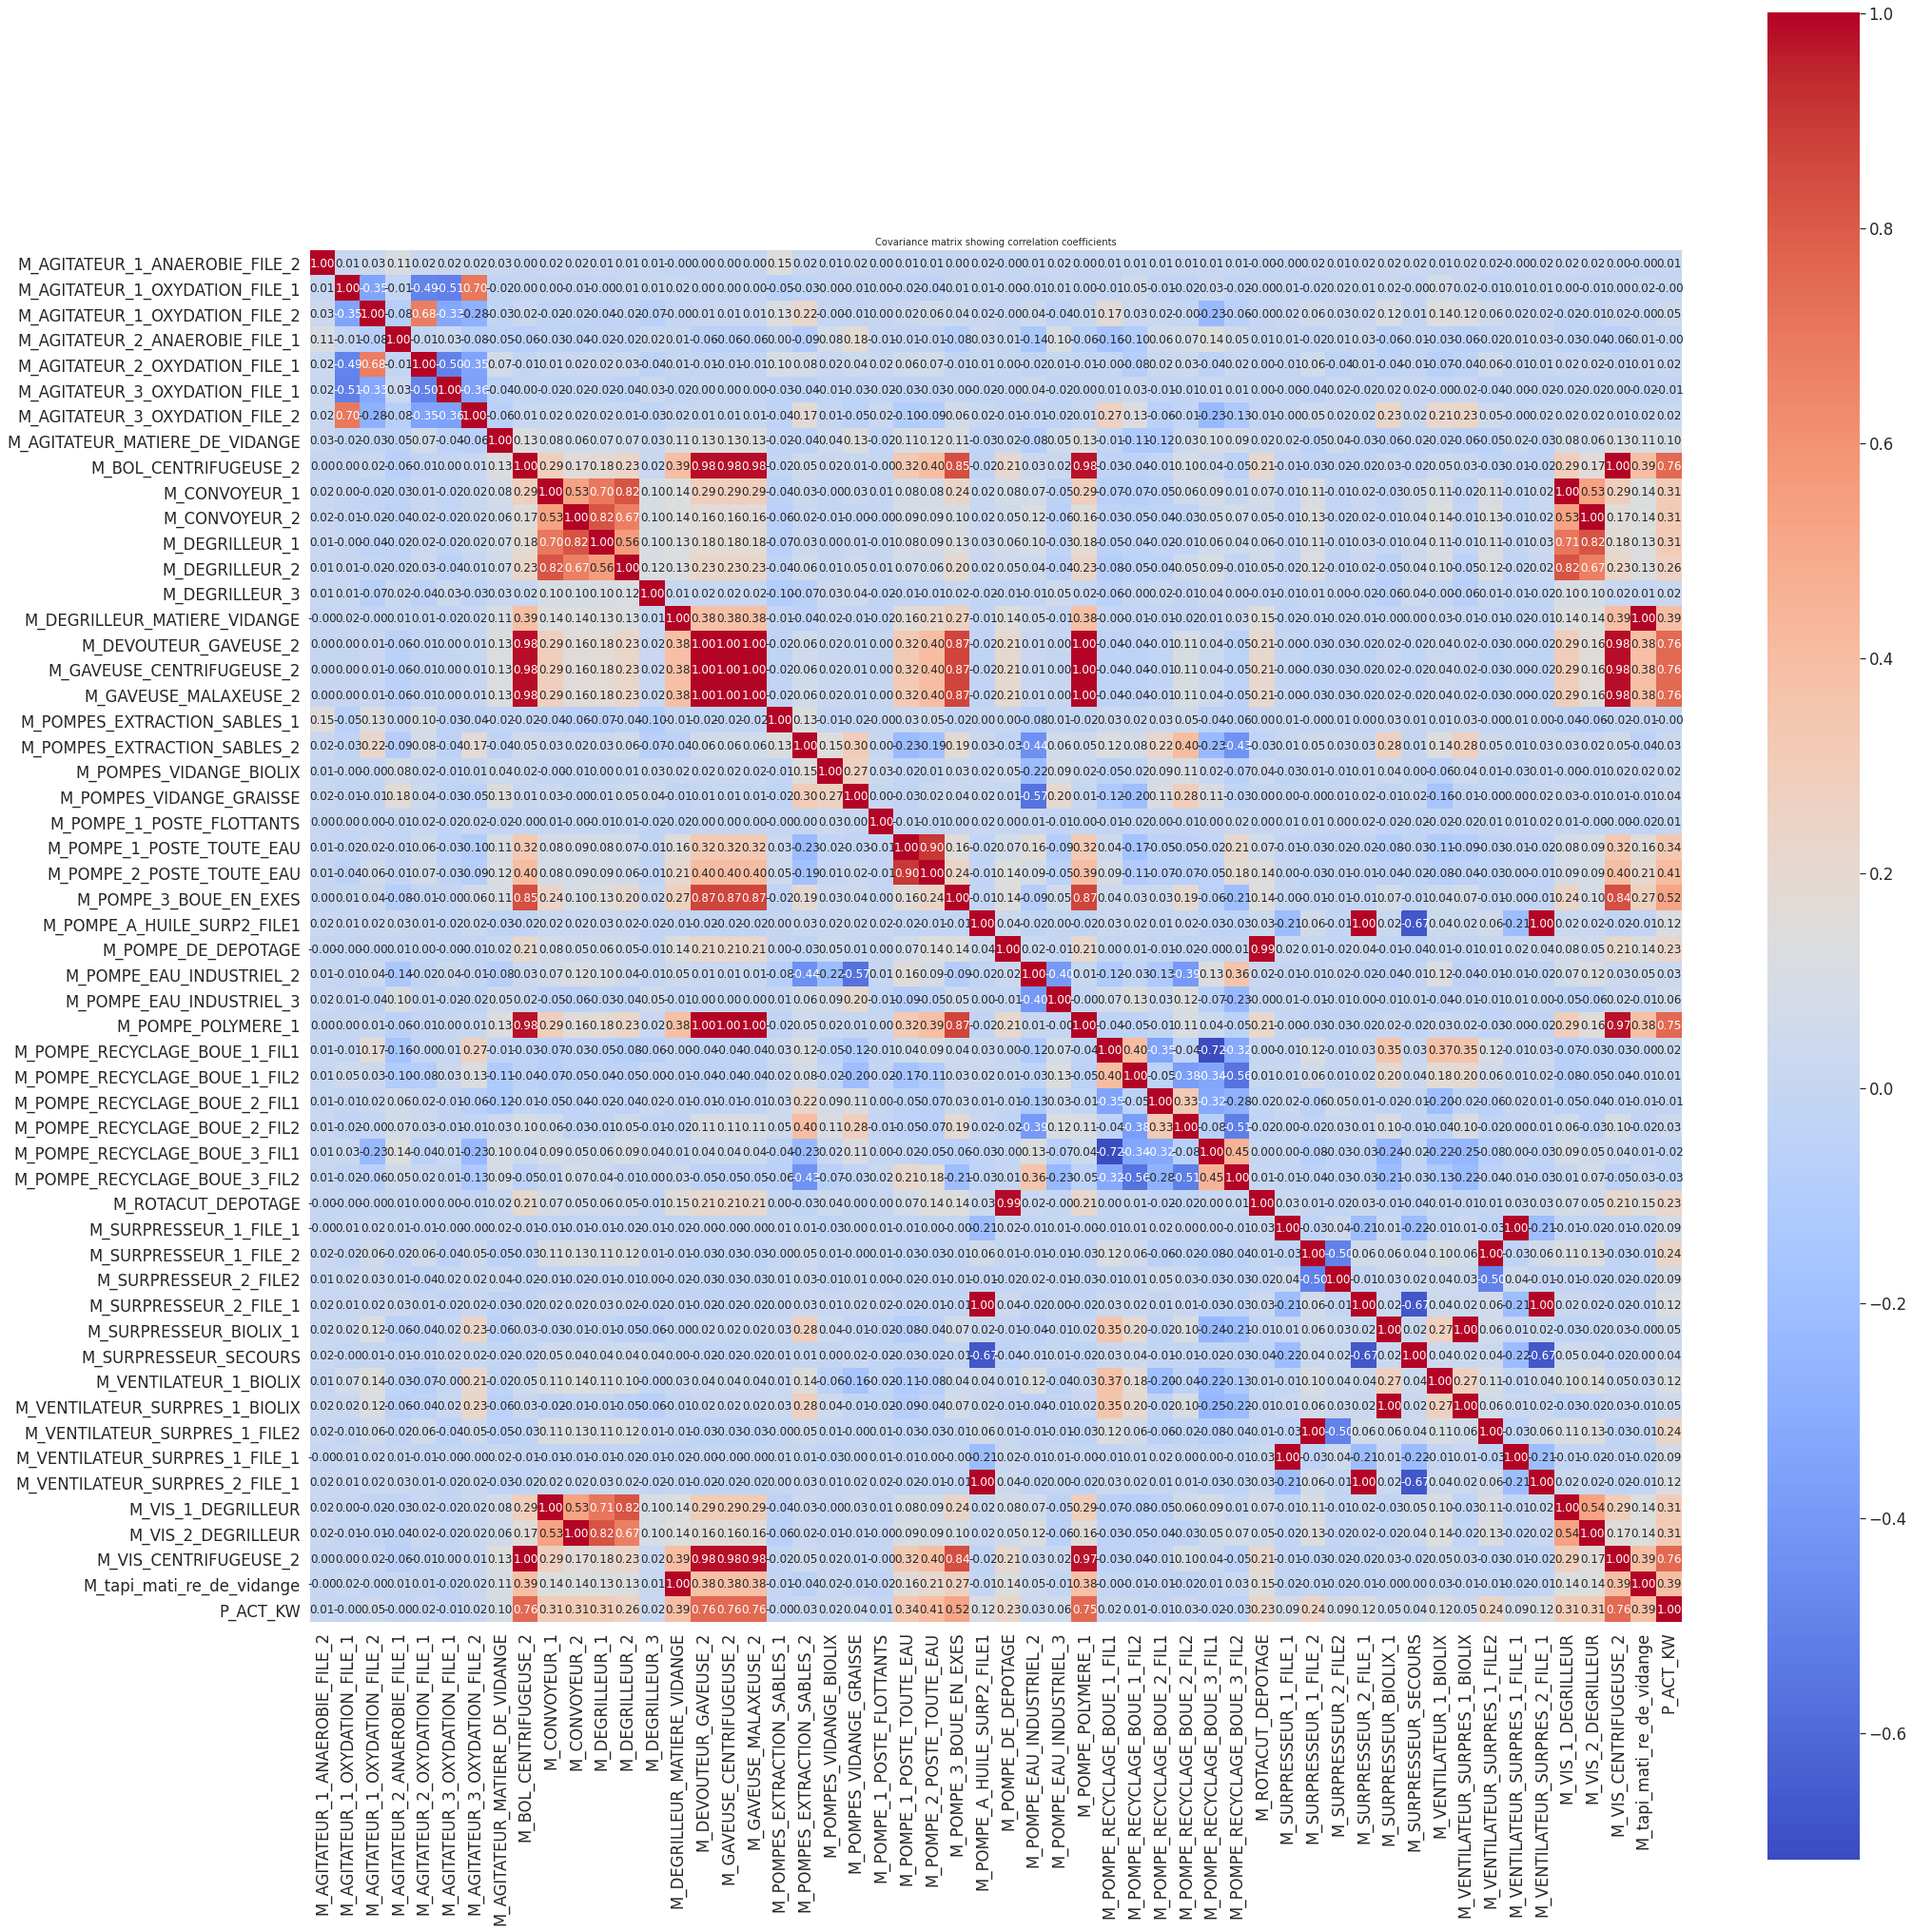

In [17]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt
import numpy as np

cols = list(data.columns)
stdsc = StandardScaler() 
X_std = stdsc.fit_transform(data[cols].iloc[:,range(0,54)].values)
cov_mat =np.cov(X_std.T)
plt.figure(figsize=(30,30))
sns.set(font_scale=1.5)
hm = sns.heatmap(cov_mat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12},
                 cmap='coolwarm',                 
                 yticklabels=cols,
                 xticklabels=cols)
plt.title('Covariance matrix showing correlation coefficients', size = 10)
plt.tight_layout()
plt.show()



In [24]:
df_feat_cor = pd.DataFrame(data={'coef':cov_mat[53,:]},index=cols)

In [26]:
df_feat_cor_selec = df_feat_cor[df_feat_cor['coef']>0.1]

In [28]:
feat_select  = list(df_feat_cor_selec.index)

In [29]:
dataset = data[feat_select].values
	# split into input (X) and output (y) variables
X = dataset[:, :-1]
y = dataset[:,-1]

In [30]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state = 0)

#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

linlasso = Lasso(alpha=0.1, max_iter = 10000).fit(X_train, y_train)
linreg   = LinearRegression().fit(X_train, y_train)


print('Non-zero features: {}'
     .format(np.sum(linlasso.coef_ != 0)))
print('R-squared score (training): {:.3f}'
     .format(linlasso.score(X_train, y_train)))
print('R-squared score (test): {:.3f}\n'
     .format(linlasso.score(X_test, y_test)))


print('Lin R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('Lin R-squared score (test): {:.3f}\n'
     .format(linreg.score(X_test, y_test)))



Non-zero features: 15
R-squared score (training): 0.767
R-squared score (test): 0.740

Lin R-squared score (training): 0.772
Lin R-squared score (test): 0.739



# Feature reduction with PCA

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

sc_y = StandardScaler() 

train_score = []
test_score = []
cum_variance = []

dataset = data.values
	# split into input (X) and output (y) variables
X = dataset[:, :-1]
y = dataset[:,-1]


for i in range(1,52):
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4, random_state=0)
    y_train_std = sc_y.fit_transform(y_train[:, np.newaxis]).flatten()
    
    pipe_lr = Pipeline([('scl', StandardScaler()),
                        ('pca', PCA(n_components=i)),
                        ('slr',   LinearRegression())]) 
    pipe_lr.fit(X_train, y_train_std)
    y_train_pred_std = pipe_lr.predict(X_train)
    y_test_pred_std = pipe_lr.predict(X_test)
    y_train_pred=sc_y.inverse_transform(y_train_pred_std)
    y_test_pred=sc_y.inverse_transform(y_test_pred_std)
    train_score = np.append(train_score, 
                            r2_score(y_train, y_train_pred))
    test_score = np.append(test_score, 
                           r2_score(y_test, y_test_pred))
    cum_variance = np.append(cum_variance, np.sum(pipe_lr.fit(X_train, y_train).named_steps['pca'].explained_variance_ratio_))

In [43]:
pipe_lr['slr'].coef_

array([ 1.43205874e+01, -6.45535057e-01,  3.85225233e+00,  1.36230157e+00,
       -2.16317391e+00,  2.53745936e+00, -2.06323871e+00,  4.44520124e+00,
       -2.59246599e+00, -1.44292909e+00,  2.27815472e-01,  3.31437840e+00,
        1.20156319e-01,  2.14756958e-01, -5.05587886e+00, -6.11586641e-01,
       -2.93300612e-01,  7.64090849e-01,  2.47174171e+00, -4.41963867e+00,
        1.65549121e+00,  2.13771112e+00, -2.31854546e+00,  6.42700556e+00,
        6.84917292e+00,  1.44624264e+01,  1.39258242e+01, -2.70218342e+00,
        6.52731696e+00,  1.41010792e+00,  3.09045258e+00,  2.00473755e+01,
        2.07129349e+01,  3.01916903e+01, -1.77659454e+00,  7.00487783e-01,
       -1.62924052e-01, -1.63541500e+01, -3.43884607e+00, -9.99379288e-02,
       -3.43709518e+01, -6.35159328e+00, -2.41199929e+01,  7.82996450e+00,
       -1.46984273e+01,  3.28300381e+01, -8.35582673e+00,  6.76377614e+00,
       -4.31534878e+02, -2.92365415e+02,  2.39626578e+01])

In [40]:
dir(pipe_lr)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_estimator_type',
 '_final_estimator',
 '_fit',
 '_get_param_names',
 '_get_params',
 '_get_tags',
 '_inverse_transform',
 '_iter',
 '_log_message',
 '_more_tags',
 '_pairwise',
 '_replace_estimator',
 '_required_parameters',
 '_set_params',
 '_transform',
 '_validate_names',
 '_validate_steps',
 'classes_',
 'decision_function',
 'fit',
 'fit_predict',
 'fit_transform',
 'get_params',
 'inverse_transform',
 'memory',
 'named_steps',
 'predict',
 'p

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
import numpy as np

parameters = {'alpha':[0.001,0.01, 0.05,0.1,0.5,1,2,3,5,10,50,10]}
mod = Lasso(max_iter = 10000)
mod_cv = GridSearchCV(mod, parameters)
mod_cv.fit(X_train_scaled, y_train)

NameError: ignored

In [ ]:

print('R-squared score (training): {:.3f}'
     .format(mod_cv.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}\n'
     .format(mod_cv.score(X_test_scaled, y_test)))

R-squared score (training): 0.930
R-squared score (test): 0.915



In [ ]:
from scipy.optimize import lsq_linear



lb = np.zeros(53)

res = lsq_linear(X_train, y_train, bounds=(lb, np.inf), lsmr_tol='auto', verbose=1)

The relative change of the cost function is less than `tol`.
Number of iterations 76, initial cost 7.9206e+11, final cost 5.1853e+05, first-order optimality 3.12e-10.


In [ ]:
import plotly.express as px
fig = px.scatter(x=df_score['Score'], y=df_score['P-value'])
fig.show()

In [ ]:
df_coeflsq = pd.DataFrame(data={'Variable':varselected,'Coef':res.x})

In [ ]:
import plotly.graph_objects as go


fig = go.Figure([go.Bar(x=varselected, y=res.x)])
fig.show()

In [ ]:
res.x.shape
X_test.shape
Y_predit = np.dot(X_test,res.x)

In [ ]:
Y_predit

array([139.99784843, 156.10198737, 163.5251207 , 180.31556689,
       148.49358956, 182.46963766, 178.25952559, 235.36676721,
       285.43493327, 208.85300786, 156.39030978, 230.93764365,
       188.18815042, 155.97239893, 280.47763959, 183.17342765,
       173.09813166, 296.32514485, 178.41917399, 155.08315529,
       131.74610422, 174.80683873, 245.13818064, 244.79165482,
       190.3233246 , 229.23927298, 195.94101546, 197.55761929,
       157.30921458, 118.50351401, 185.42111114, 170.59551094,
       304.37071001, 209.62101998, 171.67131514, 245.74083707,
       179.81401914, 181.07917778, 225.13453468, 171.24870517,
       192.35199505, 284.45952148, 174.94385903, 166.29962094,
       185.59907977, 187.9359283 , 171.5747941 , 261.39205396,
       170.17971785, 336.18467378, 191.37239032, 271.82782113,
       190.61075385, 179.71980232, 213.7669948 , 176.42922475,
       187.76689933, 173.14648883, 214.44113876, 205.10936061,
       177.40544128, 174.79567963, 193.92112897, 235.85

In [ ]:
lb = np.zeros((2587,1))

In [ ]:
var_name = list(data.columns)

df_score = pd.DataFrame(data={'Variable':varselected,'Coef':linreg.coef_})

In [ ]:
df_score

,Variable,Coef
0,M_AGITATEUR_1_ANAEROBIE_FILE_2,1175.781161
1,M_AGITATEUR_1_OXYDATION_FILE_1,-690.265050
2,M_AGITATEUR_1_OXYDATION_FILE_2,-0.787636
3,M_AGITATEUR_2_ANAEROBIE_FILE_1,4.780078
4,M_AGITATEUR_2_OXYDATION_FILE_1,-690.370507
5,M_AGITATEUR_3_OXYDATION_FILE_1,-691.247376
6,M_AGITATEUR_3_OXYDATION_FILE_2,-2.003117
7,M_AGITATEUR_MATIERE_DE_VIDANGE,13.996764
8,M_BOL_CENTRIFUGEUSE_2,322.855422
9,M_CONVOYEUR_1,-34.255066


In [ ]:

import plotly.graph_objects as go
import numpy as np



x = np.arange(len(y_test))

fig = go.Figure(layout={
    'title' : 'Valeurprédite/valeur mesurée',
    'yaxis' : {
        'title' : 'Conso STEP'
    }
})


p1 = go.Scatter({
    'mode' : 'lines',
    'x' : x,
    'y' : Y_predit,
    'name' : 'Prediction'})
p2 = go.Scatter({
    'mode' : 'lines',
    'x' : x,
    'y' : y_test,
    'name' : 'Mesure'})

fig.add_trace(p1)
fig.add_trace(p2)


fig.show()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
# Set lower and upper quantile
LOWER_ALPHA = 0.1
UPPER_ALPHA = 0.9
# Each model has to be separate
lower_model = GradientBoostingRegressor(loss="quantile",                   
                                        alpha=LOWER_ALPHA)
# The mid model will use the default loss
mid_model = GradientBoostingRegressor(loss="ls")
upper_model = GradientBoostingRegressor(loss="quantile",
                                        alpha=UPPER_ALPHA)

In [ ]:
# Fit models
lower_model.fit(X_train, y_train)
mid_model.fit(X_train, y_train)
upper_model.fit(X_train, y_train)
# Record actual values on test set
predictions = pd.DataFrame(y_test)
# Predict
predictions['lower'] = lower_model.predict(X_test)
predictions['mid'] = mid_model.predict(X_test)
predictions['upper'] = upper_model.predict(X_test)

In [ ]:
predictions

,0,lower,mid,upper
0,143.166667,139.128683,148.201711,184.564265
1,158.500000,160.341791,172.343400,201.753584
2,133.833333,120.370571,130.490515,191.045136
3,178.833333,177.117191,187.285670,192.656345
4,150.333333,140.753653,154.488135,181.053574
...,...,...,...,...
858,287.500000,251.997183,305.336729,314.911619
859,252.166667,218.940409,241.683059,252.064972
860,209.166667,197.546666,208.985833,210.653614
861,233.500000,208.725795,228.915869,226.679003


In [ ]:

test_pred = linreg.predict(X_test_scaled)


lower, prediction, upper = get_prediction_interval(test_pred, y_test, test_pred, pi=.95)

In [ ]:
len(test_pred)

863

In [ ]:
x = range(len(test_pred))
print(len(x))

863


In [ ]:
import plotly.graph_objects as go
import numpy as np



x = np.arange(len(test_pred))

fig = go.Figure(layout={
    'title' : 'Engine Displacement in Liters vs Highway MPG',
    'xaxis' : {
        'title' : 'Engine Displacement in Liters'
    },
    'yaxis' : {
        'title' : 'Highway MPG'
    }
})


p2 = go.Scatter({
    'mode' : 'lines',
    'x' : x,
    'y' : prediction,
    'name' : 'Regression',
})
#Add a lower bound for the confidence interval, white
p3 = go.Scatter({
    'mode' : 'lines',
    'x' : x,
    'y' : lower,
    'name' : 'Lower 95% CI',
    'showlegend' : False,
    'line' : {
        'color' : 'white'
    }
})
# Upper bound for the confidence band, transparent but with fill
p4 = go.Scatter( {
    'type' : 'scatter',
    'mode' : 'lines',
    'x' : x,
    'y' : upper,
    'name' : '95% CI',
    'fill' : 'tonexty',
    'line' : {
        'color' : 'white'
    },
    'fillcolor' : 'rgba(255, 127, 14, 0.3)'
})


fig.add_trace(p2)
fig.add_trace(p3)
fig.add_trace(p4)




fig.show()


In [ ]:
import plotly.graph_objects as go
import numpy as np



x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
x_rev = x[::-1]

# Line 1
y1 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y1_upper = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
y1_lower = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
y1_lower = y1_lower[::-1]

# Line 2
y2 = [5, 2.5, 5, 7.5, 5, 2.5, 7.5, 4.5, 5.5, 5]
y2_upper = [5.5, 3, 5.5, 8, 6, 3, 8, 5, 6, 5.5]
y2_lower = [4.5, 2, 4.4, 7, 4, 2, 7, 4, 5, 4.75]
y2_lower = y2_lower[::-1]

# Line 3
y3 = [10, 8, 6, 4, 2, 0, 2, 4, 2, 0]
y3_upper = [11, 9, 7, 5, 3, 1, 3, 5, 3, 1]
y3_lower = [9, 7, 5, 3, 1, -.5, 1, 3, 1, -1]
y3_lower = y3_lower[::-1]


fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x+x_rev,
    y=y1_upper+y1_lower,
    fill='toself',
    fillcolor='rgba(0,100,80,0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False,
    name='Fair',
))
fig.add_trace(go.Scatter(
    x=x+x_rev,
    y=y2_upper+y2_lower,
    fill='toself',
    fillcolor='rgba(0,176,246,0.2)',
    line_color='rgba(255,255,255,0)',
    name='Premium',
    showlegend=False,
))
fig.add_trace(go.Scatter(
    x=x+x_rev,
    y=y3_upper+y3_lower,
    fill='toself',
    fillcolor='rgba(231,107,243,0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False,
    name='Ideal',
))
fig.add_trace(go.Scatter(
    x=x, y=y1,
    line_color='rgb(0,100,80)',
    name='Fair',
))
fig.add_trace(go.Scatter(
    x=x, y=y2,
    line_color='rgb(0,176,246)',
    name='Premium',
))
fig.add_trace(go.Scatter(
    x=x, y=y3,
    line_color='rgb(231,107,243)',
    name='Ideal',
))

fig.update_traces(mode='lines')
fig.show()

In [ ]:
x_rev

array([862, 861, 860, 859, 858, 857, 856, 855, 854, 853, 852, 851, 850,
       849, 848, 847, 846, 845, 844, 843, 842, 841, 840, 839, 838, 837,
       836, 835, 834, 833, 832, 831, 830, 829, 828, 827, 826, 825, 824,
       823, 822, 821, 820, 819, 818, 817, 816, 815, 814, 813, 812, 811,
       810, 809, 808, 807, 806, 805, 804, 803, 802, 801, 800, 799, 798,
       797, 796, 795, 794, 793, 792, 791, 790, 789, 788, 787, 786, 785,
       784, 783, 782, 781, 780, 779, 778, 777, 776, 775, 774, 773, 772,
       771, 770, 769, 768, 767, 766, 765, 764, 763, 762, 761, 760, 759,
       758, 757, 756, 755, 754, 753, 752, 751, 750, 749, 748, 747, 746,
       745, 744, 743, 742, 741, 740, 739, 738, 737, 736, 735, 734, 733,
       732, 731, 730, 729, 728, 727, 726, 725, 724, 723, 722, 721, 720,
       719, 718, 717, 716, 715, 714, 713, 712, 711, 710, 709, 708, 707,
       706, 705, 704, 703, 702, 701, 700, 699, 698, 697, 696, 695, 694,
       693, 692, 691, 690, 689, 688, 687, 686, 685, 684, 683, 68

In [ ]:
X_test_scaled[0]

array([1.        , 0.        , 0.        , 0.36388889, 0.27916667,
       0.20861111, 0.31722222, 0.        , 0.        , 0.        ,
       0.        , 0.56361111, 0.07388889, 0.07861111, 0.        ,
       0.12027778, 0.        , 0.22555556, 0.        , 0.        ,
       0.        , 0.365     , 0.        , 0.12027778, 0.05111111,
       0.        , 0.05638889, 0.055     , 0.365     , 0.        ,
       0.12027778, 0.365     , 0.27972222, 0.        , 0.        ])